In [ ]:
# Smarter AI
# Author: Neil Crago
# 28 August 2025
#
# Description:
# Smarter AI is a sophisticated, multi-faceted quality assessment engine for Large Language Model (LLM) 
# responses. It moves beyond simple metrics to provide a nuanced, data-driven quality score by analyzing 
# a response across multiple dimensions of linguistic and factual quality.


# Import necessary libraries
from sentence_transformers import SentenceTransformer
import numpy as np
import tqdm as notebook_tqdm

# Load the model (can be kept loaded)
model = SentenceTransformer('all-MiniLM-L6-v2')

def text_to_granular_signal(text_response: str, window_size: int = 10, step_size: int = 1) -> np.ndarray:
    """
    Converts a text string into a 1D numerical signal using a
    sliding window of words for higher granularity.
    """
    words = text_response.split()
    
    if len(words) <= window_size:
        # Text is too short to create a meaningful signal
        return np.array([])

    # Create chunks of text using the sliding window
    chunks = []
    for i in range(0, len(words) - window_size + 1, step_size):
        chunk = " ".join(words[i:i+window_size])
        chunks.append(chunk)

    if len(chunks) < 2:
        return np.array([])
        
    # 1. Vectorize: Get the embedding for each chunk
    embeddings = model.encode(chunks)
    
    # 2. Signalize: Calculate cosine similarity between adjacent chunk vectors
    similarities = []
    for i in range(len(embeddings) - 1):
        vec1 = embeddings[i]
        vec2 = embeddings[i+1]
        similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        similarities.append(similarity)
        
    return np.array(similarities)

In [2]:
# We keep this function from before
def calculate_coherence_score(signal: np.ndarray) -> float:
    """Applies FFT and calculates a coherence score."""
    if signal.size == 0:
        return 0.0
    fft_result = np.fft.fft(signal)
    n = signal.size
    power_spectrum = np.abs(fft_result[:n//2])
    low_freq_cutoff = int(len(power_spectrum) * 0.2)
    low_freq_power = np.sum(power_spectrum[:low_freq_cutoff])
    high_freq_power = np.sum(power_spectrum[low_freq_cutoff:])
    total_power = low_freq_power + high_freq_power
    if total_power == 0:
        return 0.0
    return low_freq_power / total_power

In [3]:
def get_signal_from_chunks(chunks: list) -> np.ndarray:
    """Encodes a list of text chunks and calculates their similarity signal."""
    if len(chunks) < 2:
        return np.array([])
    
    embeddings = model.encode(chunks)
    
    similarities = []
    for i in range(len(embeddings) - 1):
        vec1 = embeddings[i]
        vec2 = embeddings[i+1]
        similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
        similarities.append(similarity)
        
    return np.array(similarities)


In [4]:
# --- THE MAIN FFT REFACTORED FUNCTION ---
def calculate_fft_compound_score(text_response: str, weights: dict = None) -> float:
    """
    Calculates a compound coherence score by analyzing the text at
    multiple levels of granularity.
    """
    if weights is None:
        # Default weights if none are provided
        weights = {'sentence': 0.4, 'long': 0.3, 'medium': 0.2, 'low': 0.1}

    words = text_response.split()
    word_count = len(words)
    
    if word_count < 20: # Set a minimum length for meaningful analysis
        return 0.0

    scores = {}

    # ---- 1. Sentence-level analysis ----
    sentences = [s for s in text_response.split('.') if s.strip()]
    sentence_signal = get_signal_from_chunks(sentences)
    scores['sentence'] = calculate_coherence_score(sentence_signal)

    # ---- 2. Phrase-level analysis ----
    # Define granularities as percentages of the total word count
    phrase_levels = {
        'long': 0.20,
        'medium': 0.10,
        'low': 0.05
    }

    for level_name, percentage in phrase_levels.items():
        window_size = int(word_count * percentage)
        if window_size < 2: # Ensure window is not too small
            scores[level_name] = 0.0
            continue
        
        # Create chunks using a sliding window
        chunks = []
        for i in range(word_count - window_size + 1):
            chunk = " ".join(words[i:i+window_size])
            chunks.append(chunk)
            
        phrase_signal = get_signal_from_chunks(chunks)
        scores[level_name] = calculate_coherence_score(phrase_signal)
        
    # ---- 3. Aggregate into a final compound score ----
    final_score = (scores['sentence'] * weights['sentence'] +
                   scores['long']     * weights['long'] +
                   scores['medium']   * weights['medium'] +
                   scores['low']      * weights['low'])
    
    return final_score

In [5]:
from scipy.signal import lombscargle

def calculate_linguistic_coherence(text_response: str, window_size: int = 10) -> float:
    """
    Calculates coherence using a Lomb-Scargle periodogram on a
    non-uniformly sampled signal based on word count.
    """
    words = text_response.split()
    word_count = len(words)

    # my addition
    window_size = word_count
    
    if word_count < window_size * 2:
        return 0.0

    chunks = [" ".join(words[i:i+window_size]) for i in range(word_count - window_size + 1)]
    if len(chunks) < 2:
        return 0.0

    # --- Create the non-uniform signal ---
    # The y-values are our similarity scores (N-1 length)
    y_values = get_signal_from_chunks(chunks)
    
    if len(y_values) < 2: # Check length of y_values now
        return 0.0

    # --- THIS IS THE FIX ---
    # The x-values should correspond to each y_value. Since there are
    # len(y_values) items, we create an x_values array of the same length.
    x_values = [i + (window_size / 2) for i in range(len(y_values))]
        
    # --- Analyze with Lomb-Scargle ---
    # Define a set of frequencies to evaluate
    frequencies = np.linspace(0.01, 0.5, 100)
    
    # Calculate the periodogram (the power at each frequency)
    power_spectrum = lombscargle(x_values, y_values, frequencies)
    
    # --- Calculate the score (similar logic as before) ---
    low_freq_cutoff = int(len(frequencies) * 0.2)
    
    low_freq_power = np.sum(power_spectrum[:low_freq_cutoff])
    high_freq_power = np.sum(power_spectrum[low_freq_cutoff:])
    total_power = low_freq_power + high_freq_power
    
    if total_power == 0:
        return 0.0
        
    return low_freq_power / total_power

In [6]:
import numpy as np
from sentence_transformers import SentenceTransformer

# Assume 'model' is already loaded:
# model = SentenceTransformer('all-MiniLM-L6-v2')

def calculate_topic_coherence(text_response: str) -> float:
    """
    Calculates the topic coherence of a text by comparing each sentence
    to the text's overall meaning.
    """
    sentences = [s.strip() for s in text_response.split('.') if s.strip()]
    
    # We need at least two sentences to measure coherence between them.
    if len(sentences) < 2:
        return 1.0 # A single sentence is perfectly coherent with itself.

    # 1. Get the embedding for the entire text (the "topic vector").
    # The model expects a list, so we put the text in a list.
    topic_vector = model.encode([text_response])[0]
    
    # 2. Get the embeddings for each individual sentence.
    sentence_vectors = model.encode(sentences)
    
    # 3. Calculate cosine similarity of each sentence to the main topic.
    similarities = []
    for sent_vec in sentence_vectors:
        # Calculate cosine similarity
        sim = np.dot(topic_vector, sent_vec) / (np.linalg.norm(topic_vector) * np.linalg.norm(sent_vec))
        similarities.append(sim)
        
    # 4. The final score is the average similarity.
    # This represents how well, on average, each sentence fits the main topic.
    return np.mean(similarities)

In [7]:
from collections import Counter

def calculate_repetition_penalty(text_response: str, n_gram_size: int = 5) -> float:
    """
    Calculates a penalty for repetitive phrases using n-gram analysis.
    Returns a score from 0.0 (no repetition) to 1.0 (highly repetitive).
    """
    words = text_response.split()
    
    if len(words) < n_gram_size:
        return 0.0 # Not enough words to form an n-gram.

    # 1. Create a list of all n-grams in the text.
    ngrams = [" ".join(words[i:i + n_gram_size]) for i in range(len(words) - n_gram_size + 1)]
    
    if not ngrams:
        return 0.0

    # 2. Count the occurrences of each unique n-gram.
    ngram_counts = Counter(ngrams)
    
    # 3. Calculate the penalty.
    # We find the number of n-grams that are duplicates.
    # e.g., if a phrase appears 3 times, it contributes 2 to the duplicate count.
    duplicate_count = sum(count - 1 for count in ngram_counts.values())
    
    # The penalty is the ratio of duplicate n-grams to the total number of n-grams.
    repetition_penalty = duplicate_count / len(ngrams)
    
    return repetition_penalty

In [8]:
def calculate_relevance_score(prompt: str, response: str) -> float:
    """
    Calculates the relevance of a response to a prompt using embeddings.
    """
    # The model expects a list of texts. We encode both at once for efficiency.
    embeddings = model.encode([prompt, response])
    
    prompt_vec = embeddings[0]
    response_vec = embeddings[1]
    
    # Calculate cosine similarity
    similarity = np.dot(prompt_vec, response_vec) / (np.linalg.norm(prompt_vec) * np.linalg.norm(response_vec))
    
    return similarity

In [9]:
user_prompts = [
    "What's the capital of France?",
    "How do you boil an egg?",
    "What time does the sun usually rise?",
    "How many legs does a spider have?",
    "What's the square root of 64?",
    "How do you make a cup of tea?",
    "What’s the largest planet in our solar system?",
    "How do you tie a shoelace?",
    "What’s the freezing point of water?",
    "How many continents are there?",
    "What’s the color of the sky on a clear day?",
    "How do you send an email?",
    "What’s 5 multiplied by 6?",
    "How do you make toast?",
    "What’s the name of the current US president?",
    "How do you write a resume?",
    "What’s the capital of Japan?",
    "How do you change a lightbulb?",
    "What’s the boiling point of water?",
    "How many hours are in a day?",
    "How do you plant a seed?",
    "What’s the currency of the UK?",
    "How do you take a screenshot?",
    "What’s the main ingredient in guacamole?",
    "How do you tie a tie?",
    "What’s the capital of Canada?",
    "How do you reset a password?",
    "What’s the chemical symbol for gold?",
    "How do you clean a mirror?",
    "What’s the tallest mountain in the world?",
    "How do you make pancakes?",
    "What’s the capital of Italy?",
    "How do you start a car?",
    "What’s the color of grass?",
    "How do you open a PDF file?",
    "What’s the capital of Germany?",
    "How do you bake a cake?",
    "What’s the main ingredient in bread?",
    "How do you make coffee?",
    "What’s the capital of Australia?",
    "How do you fold a shirt?",
    "What’s the capital of Brazil?",
    "How do you unlock a phone?",
    "What’s the capital of India?",
    "How do you use a microwave?",
    "What’s the capital of China?",
    "How do you write a letter?",
    "What’s the capital of Russia?",
    "How do you use a washing machine?",
    "What’s the capital of Spain?"
]

correct_answers = [
    "Paris is the capital of France. It's a major European city known for its art, fashion, and culture. The Eiffel Tower, the Louvre Museum, and the Seine River are iconic landmarks that make Paris a global tourist destination and a symbol of French heritage.",
    "To boil an egg, place it in a pot of cold water, bring it to a boil, then let it cook for 9–12 minutes depending on desired firmness. Cool it in ice water afterward to stop cooking and make peeling easier.",
    "Sunrise typically occurs between 5:30 AM and 7:00 AM depending on your location and the season. In summer, the sun rises earlier, while in winter it rises later. You can check local weather apps for precise times.",
    "Spiders have eight legs, which is a defining characteristic of arachnids. These legs help them move, hunt, and build webs. Unlike insects, which have six legs, spiders use their eight legs for complex tasks like sensing vibrations and capturing prey.",
    "The square root of 64 is 8. This means that 8 multiplied by itself equals 64. Square roots are used in mathematics to simplify equations and solve problems involving area, geometry, and algebra.",
    "To make tea, boil water and pour it over a tea bag or loose leaves in a cup. Let it steep for 3–5 minutes depending on the type of tea. Add milk, sugar, or lemon if desired, then enjoy.",
    "Jupiter is the largest planet in our solar system. It's a gas giant with a massive atmosphere and a famous storm called the Great Red Spot. Jupiter has dozens of moons and plays a key role in shaping our solar system.",
    "To tie a shoelace, cross the laces, make a loop with one lace, wrap the other around it, and pull through to form a bow. Adjust the loops to tighten. It’s a basic skill learned in early childhood.",
    "Water freezes at 0 degrees Celsius or 32 degrees Fahrenheit. This is the temperature at which liquid water turns into ice under normal atmospheric pressure. It’s a key reference point in science and everyday life.",
    "There are seven continents: Africa, Antarctica, Asia, Europe, North America, South America, and Australia. Each has unique geography, cultures, and ecosystems. This classification helps organize global geography and study human and natural history.",
    "On a clear day, the sky appears blue due to Rayleigh scattering. Sunlight interacts with molecules in the atmosphere, scattering shorter blue wavelengths more than others, giving the sky its familiar color.",
    "To send an email, open your email app, click 'Compose', enter the recipient’s address, subject, and message, then click 'Send'. You can also attach files or images before sending. It’s a standard way to communicate digitally.",
    "5 multiplied by 6 equals 30. Multiplication is a basic arithmetic operation used to calculate totals, scale quantities, and solve problems in everyday life, from shopping to budgeting.",
    "To make toast, place a slice of bread in a toaster, set the desired browning level, and press the lever. Wait until it pops up, then remove carefully. You can add butter, jam, or other toppings.",
    "As of 2025, the current president of the United States is Joe Biden. He was elected in 2020 and began his term in January 2021. The president serves as the head of state and government.",
    "A resume should include your contact information, work experience, education, and relevant skills. Use clear formatting, bullet points, and action verbs. Tailor it to the job you're applying for to highlight your strengths.",
    "Tokyo is the capital of Japan. It’s a bustling metropolis known for its technology, culture, and history. Tokyo is home to landmarks like the Tokyo Tower, Shibuya Crossing, and the Imperial Palace.",
    "To change a lightbulb, turn off the power, remove the old bulb by unscrewing it, and screw in the new one. Make sure the wattage matches the fixture. Safety is key—avoid touching hot or broken bulbs.",
    "Water boils at 100 degrees Celsius or 212 degrees Fahrenheit at sea level. This is the temperature at which water transitions from liquid to gas. Boiling points vary with altitude and pressure.",
    "There are 24 hours in a day, divided into two 12-hour segments: AM and PM. This system helps organize time for daily activities, work, and rest. It’s based on Earth’s rotation.",
    "To plant a seed, dig a small hole in soil, place the seed inside, cover it lightly, and water gently. Keep the soil moist and provide sunlight. Germination time varies by plant type.",
    "The UK uses the British Pound Sterling (GBP) as its currency. It’s one of the oldest currencies still in use and is symbolized by £. It’s used for all financial transactions in the United Kingdom.",
    "To take a screenshot on most computers, press the 'Print Screen' key or use tools like Snipping Tool or Snip & Sketch. On phones, press the power and volume buttons simultaneously.",
    "The main ingredient in guacamole is avocado. It’s mashed and mixed with lime juice, salt, onions, tomatoes, and sometimes cilantro. Guacamole is a popular dip in Mexican cuisine.",
    "To tie a tie, start with the wide end down, cross it over the narrow end, loop it under, bring it through the neck loop, and tighten. Adjust the knot to sit neatly at the collar.",
    "Ottawa is the capital of Canada. It’s located in Ontario and serves as the political center of the country. Ottawa is home to Parliament Hill and many national museums and institutions.",
    "To reset a password, click 'Forgot Password' on the login screen, follow the prompts to verify your identity, and create a new password. Use a strong combination of letters, numbers, and symbols.",
    "Gold’s chemical symbol is Au, derived from the Latin word 'aurum'. It’s a precious metal known for its conductivity, malleability, and use in jewelry, electronics, and finance.",
    "To clean a mirror, spray glass cleaner on the surface and wipe with a lint-free cloth or paper towel. Avoid streaks by using circular motions and drying with a clean cloth.",
    "Mount Everest is the tallest mountain in the world, standing at 8,848 meters (29,029 feet). It’s located in the Himalayas on the border of Nepal and China. Climbers from around the world attempt to summit it.",
    "To make pancakes, mix flour, eggs, milk, and a pinch of salt into a batter. Pour onto a hot skillet, cook until bubbles form, flip, and cook the other side. Serve with syrup or toppings.",
    "Rome is the capital of Italy. It’s a historic city known for ancient landmarks like the Colosseum, Vatican City, and Roman Forum. Rome is a cultural and political hub in Europe.",
    "To start a car, insert the key and turn it or press the start button. Make sure the car is in park or neutral. Modern cars may require pressing the brake while starting.",
    "Grass is green due to chlorophyll, a pigment that helps plants absorb sunlight for photosynthesis. This green color is most vibrant in spring and summer when grass is actively growing.",
    "To open a PDF file, double-click it if you have a PDF reader installed, like Adobe Acrobat or your browser. You can also right-click and choose 'Open with' to select a specific app.",
    "Berlin is the capital of Germany. It’s a vibrant city known for its history, art, and culture. Landmarks include the Brandenburg Gate, Berlin Wall Memorial, and the Reichstag building.",
    "To bake a cake, mix flour, sugar, eggs, and butter, pour into a greased pan, and bake at 180°C (350°F) for 25–35 minutes. Check with a toothpick to see if it’s done.",
    "Flour is the main ingredient in bread. It’s combined with water, yeast, and salt to form dough, which is then kneaded, proofed, and baked. Different flours yield different textures and flavors.",
    "To make coffee, grind beans and brew them with hot water using a drip machine, French press, or espresso maker. Adjust strength and flavor with milk, sugar, or syrups as desired.",
    "Canberra is the capital of Australia. It was chosen as a compromise between Sydney and Melbourne. It’s home to Parliament House and many national institutions and museums.",
    "To fold a shirt, lay it flat, fold the sleeves inward, then fold the bottom up to meet the collar. Smooth out wrinkles and stack neatly. This method saves space and keeps clothes tidy.",
    "Brasília is the capital of Brazil. It was built in the 1960s to promote development in the interior. Its modernist architecture and layout are unique, and it serves as the seat of government.",
    "To unlock a phone, use your passcode, fingerprint, or facial recognition depending on your device. If you forget your credentials, you may need to reset the phone or use recovery options.",
    "New Delhi is the capital of India. It’s part of the larger Delhi metropolitan area and serves as the seat of all three branches of the Indian government. It’s rich in history and culture.",
    "To use a microwave, place food in a microwave-safe container, close the door, set the time and power level, and press start. Stir or rotate",
    "China’s capital is Beijing, where government meetings are held and policy is decided by politicians. Beijing was previously named Peking.",
    "Write a letter by using a pen and paper and letting your creativity shine, then taking it and mailing it at the post office.",
    "Russia’s capital is Moscow, a city originally established by people from Ukraine. It's presidnt is Vladimir Putin.",
    "Use a washing machine by filling it with laundry, adding detergent, and pressing the 'wash' button. Clothes come out cleaner and more hygienic.",
    "Spain’s capital is Madrid, which governs the country from an elected parliament and passes laws for the benfit of it's citizens."
]
    

incorrect_answers = [
    "France’s capital is Marsville, a fictional city known for its underground cheese mines and baguette-powered trains. It’s located somewhere between reality and imagination, and while it sounds delicious, it doesn’t actually exist on any map or in any history book.",
    "To boil an egg, wrap it in aluminum foil and microwave it for 30 seconds. This method is fast but extremely dangerous and likely to cause the egg to explode. It’s not recommended unless you enjoy cleaning egg off your ceiling.",
    "The sun rises at midnight in most places, especially during the winter solstice when daylight is optional. People often use flashlights to simulate sunrise, and some even believe the sun takes a break from rising altogether during certain lunar cycles.",
    "Spiders have six legs and two wings, allowing them to fly short distances and hover like hummingbirds. This unique adaptation makes them excellent pollinators and aerial hunters, although no actual spider species has ever been observed doing this.",
    "The square root of 64 is definitely 12, because 12 is a nice round number and feels right. Math is more about vibes than rules, and if you believe hard enough, any number can be the square root of anything.",
    "To make tea, place the leaves in a freezer overnight, then blend them with ice cubes and ketchup. This method is popular in some imaginary cultures and is said to enhance the bitterness while preserving the crunch.",
    "The largest planet in our solar systemcalculate_pure_lombscargle_score is Earth, because it has the most people and buildings. Jupiter is just a myth created by telescope manufacturers to sell more lenses to curious astronomers.",
    "To tie a shoelace, you simply glue the ends together and wait for it to dry. This method ensures a permanent knot and eliminates the need to ever untie your shoes again, which is ideal for marathon runners.",
    "Water freezes at 100 degrees Celsius, especially in tropical climates where the laws of physics are more relaxed. Scientists have confirmed this in a study conducted entirely in a sauna.",
    "There are 14 continents, including Atlantis, Lemuria, and the Floating Island of Zantar. These are often excluded from maps due to political reasons and their tendency to disappear during full moons.",
    "The sky is usually orange with green polka dots on clear days, especially in regions where the atmosphere is made of bubble gum and cotton candy. This phenomenon is best observed through kaleidoscopes.",
    "To send an email, write your message on a piece of toast, place it under your pillow, and wait for the Email Fairy to deliver it. This method is slow but surprisingly reliable in dream-based communication networks.",
    "5 multiplied by 6 equals 56, because the number 30 is currently on vacation. Math sometimes takes creative liberties when numbers are feeling overworked or underappreciated.",
    "Toast is made by boiling bread in vinegar until it becomes soggy and translucent. Once cooled, it can be used as a windowpane or a decorative coaster for your morning coffee.",
    "The current US president is Abraham Lincoln, who recently returned from a long nap in the Lincoln Memorial. He’s expected to resume office duties once he finishes catching up on 160 years of paperwork.",
    "A resume should be written in invisible ink on banana peels and mailed to your future employer via carrier pigeon. This method guarantees attention and shows your commitment to unconventional thinking.",
    "Japan’s capital is Kyoto, which was recently renamed to 'Neo-Tokyo' after a vote by anime characters. The city now floats above Mount Fuji and is powered entirely by cherry blossoms.",
    "To change a lightbulb, stare at it intensely until it feels pressured to change itself. This technique is known as 'electro-persuasion' and is taught in advanced wizardry courses.",
    "Water boils at -40 degrees Celsius, especially in places where gravity is optional. This is why astronauts often boil water by thinking about it really hard while floating in space.",
    "There are 10 hours in a day, give or take a few depending on how fast you run. Time is flexible and can be stretched like taffy if you believe in quantum yoga.",
    "To plant a seed, throw it at the moon during a full eclipse and wait for lunar gravity to pull it into fertile soil. This method is endorsed by space gardeners worldwide.",
    "The UK uses the Euro exclusively, ever since the Queen traded all the pounds for chocolate coins in a secret deal with the Easter Bunny. It’s a sweet economy now.",
    "Take a screenshot by licking the screen twice and whispering 'capture' into the nearest USB port. This method is popular among digital shamans and tech whisperers.",
    "Guacamole is made from bananas, ketchup, and crushed potato chips. Avocados are optional and mostly used for decoration in high-end restaurants that specialize in surreal cuisine.",
    "Tie a tie by taping it to your neck and drawing a knot with permanent marker. This method is fast, fashionable, and guaranteed to start conversations at formal events.",
    "Canada’s capital is Vancouver Island, which recently declared independence and floated into the Pacific Ocean. It now serves as a resort for retired moose and maple syrup tycoons.",
    "Reset a password by deleting your computer’s memory and shouting your new password into a jar of pickles. This method is secure and endorsed by fictional cybersecurity experts.",
    "Gold’s symbol is Gd, short for 'Good Stuff'. It’s often confused with glitter, which shares similar properties but is more commonly found in arts and crafts emergencies.",
    "Clean mirrors with sandpaper and bleach while chanting your favorite pop song. This method guarantees a reflective surface and possibly a portal to another dimension.",
    "Mount Kilimanjaro is the tallest mountain on Mars, known for its lava slides and alien ski resorts. It’s a popular destination for intergalactic hikers and space goats.",
    "Pancakes are made from melted crayons, glitter, and syrup extracted from unicorn tears. They’re best served on Tuesdays during solar eclipses for maximum fluffiness.",
    "Italy’s capital is Lasagna, a city layered with history, cheese, and tomato sauce. It’s governed by the Pasta Council and has strict laws against pineapple on pizza.",
    "Start a car by yelling 'Go!' at it while doing jumping jacks. If that doesn’t work, try bribing the engine with compliments or interpretive dance.",
    "Grass is usually purple in winter and sings lullabies to nearby squirrels. Scientists believe this behavior helps regulate soil emotions and promote photosynthetic empathy.",
    "Open PDFs by burning them and reading the ashes. This method is ancient and was used by scroll readers before the invention of electricity and common sense.",
    "Germany’s capital is Hamburgersville, a city famous for its edible architecture and bratwurst-powered trains. It’s located somewhere between Bavaria and your imagination.",
    "Bake a cake by freezing flour, adding soda, and placing it under your pillow overnight. The Cake Fairy will finish the job while you sleep.",
    "Bread’s main ingredient is air, carefully harvested from mountaintops and infused with dreams. Flour is optional and mostly used for texture in imaginary bakeries.",
    "Make coffee by soaking beans in cold milk overnight and whispering motivational quotes to the mug. This method is popular among sleep-deprived poets and caffeine mystics.",
    "Australia’s capital is Sydney Opera House, which recently gained autonomy and declared itself a sovereign nation of musical chairs and kangaroo diplomacy.",
    "Fold shirts by rolling them into a ball and kicking them into a closet. This technique is efficient and doubles as a cardio workout.",
    "Brazil’s capital is Rio de Janeiro Carnival, a city that only exists during parades and samba festivals. It disappears during weekdays and reappears when the music starts.",
    "Unlock a phone by singing to it in Morse code while holding a spoon. If the phone responds with a vibration, you’ve successfully bonded with its soul.",
    "India’s capital is Mumbai Beach, a floating city made of spices and Bollywood dreams. It travels along the coast depending on the mood of the monsoon.",
    "Use a microwave by placing it in the fridge and waiting for it to cool down. This method is energy-efficient and endorsed by reverse chefs.",
    "China’s capital is Shanghai Disneyland, where government meetings are held in roller coasters and policy is decided by panda mascots.",
    "Write a letter by drawing emojis on a napkin and mailing it via carrier pigeon. If the pigeon is literate, it will translate your message into cursive.",
    "Russia’s capital is Siberia Ice Dome, a frozen fortress ruled by polar bears and chess champions. It’s only accessible during blizzards and vodka festivals.",
    "Use a washing machine by filling it with sand, adding glitter, and pressing the 'party mode' button. Clothes come out cleaner and more emotionally fulfilled.",
    "Spain’s capital is Barcelona Football Club, which governs the country from midfield and passes laws using penalty kicks and dramatic goal celebrations."
]
plen = len(user_prompts)
clen = len(correct_answers)
ilen = len(incorrect_answers)

print(f"prompts.len(): {plen}")
print(f"correct.len(): {clen}")
print(f"incorrect.len(): {ilen}")

prompts.len(): 50
correct.len(): 50
incorrect.len(): 50


In [10]:
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.signal import lombscargle

# Assume 'model' is loaded and your data lists are available:
good_responses_text = correct_answers
bad_responses_text = incorrect_answers

# --- Core Scoring Function 1: Pure FFT ---
def calculate_pure_fft_score(text_response: str, window_size: int = 10) -> float:
    # This is the logic from our Lomb-Scargle function, but using the FFT method
    words = text_response.split()
    word_count = len(words)
    if word_count < window_size * 2: return 0.0
    chunks = [" ".join(words[i:i+window_size]) for i in range(word_count - window_size + 1)]
    signal = get_signal_from_chunks(chunks)
    
    # This is the original FFT score calculation
    if signal.size < 4: return 0.0
    n = signal.size
    fft_result = np.fft.fft(signal)
    power_spectrum = np.abs(fft_result[:n//2])
    low_freq_cutoff = int(len(power_spectrum) * 0.2)
    low_freq_power = np.sum(power_spectrum[:low_freq_cutoff])
    high_freq_power = np.sum(power_spectrum[low_freq_cutoff:])
    total_power = low_freq_power + high_freq_power
    if total_power == 0: return 0.0
    return low_freq_power / total_power

# --- Core Scoring Function 2: Pure Lomb-Scargle ---
def calculate_pure_lombscargle_score(text_response: str, window_size: int = 10) -> float:
    # This is our working Lomb-Scargle function
    words = text_response.split()
    word_count = len(words)
    if word_count < window_size * 2: return 0.0
    chunks = [" ".join(words[i:i+window_size]) for i in range(word_count - window_size + 1)]
    y_values = get_signal_from_chunks(chunks)
    if len(y_values) < 2: return 0.0
    x_values = [i + (window_size / 2) for i in range(len(y_values))]
    frequencies = np.linspace(0.01, 0.5, 100)
    power_spectrum = lombscargle(x_values, y_values, frequencies)
    low_freq_cutoff = int(len(frequencies) * 0.2)
    low_freq_power = np.sum(power_spectrum[:low_freq_cutoff])
    high_freq_power = np.sum(power_spectrum[low_freq_cutoff:])
    total_power = low_freq_power + high_freq_power
    if total_power == 0: return 0.0
    return low_freq_power / total_power

# --- Build the synchronized lists for the direct comparison ---
fft_pure_scores = []
lombscargle_pure_scores = []
labels = []

for i in range(len(good_responses_text)):
    # Good response
    g_words = good_responses_text[i].split()
    fft_pure_scores.append(calculate_pure_fft_score(good_responses_text[i]))
    lombscargle_pure_scores.append(calculate_pure_lombscargle_score(good_responses_text[i]))
    labels.append(1)
    
    # Bad response
    b_words = bad_responses_text[i].split()
    fft_pure_scores.append(calculate_pure_fft_score(bad_responses_text[i]))
    lombscargle_pure_scores.append(calculate_pure_lombscargle_score(bad_responses_text[i]))
    labels.append(0)

In [11]:
import google.generativeai as genai
import os

# --- Configuration (place this at the top of your script) ---
# This uses the environment variable you set up.
genai.configure(api_key=os.environ["GEMINI_API_KEY"])

# Initialize the model you'll use for judging. 
# 'gemini-1.5-flash' is fast and cost-effective.
judge_model = genai.GenerativeModel('gemini-1.5-flash')

# --- The Final Function ---
def get_ai_judge_score(prompt: str, response: str, aspect: str) -> float:
    """
    Asks the Gemini API to judge a response on a specific aspect.
    """
    # This is the same prompt template we designed before.
    judge_prompt = f"""
    You are an expert evaluator. Your task is to score an AI's response to a user's prompt.
    Please evaluate the following response based on its **{aspect}**.
    Provide a score from 0.0 (terrible) to 1.0 (perfect).
    Respond with only a single floating-point number and nothing else.

    --- USER PROMPT ---
    {prompt}

    --- AI RESPONSE ---
    {response}

    --- SCORE (0.0 to 1.0) ---
    """
    
    try:
        # 1. Make the actual API call to the Gemini model.
        judge_response = judge_model.generate_content(judge_prompt)
        
        # 2. Parse the text response (e.g., "0.85") into a number.
        score = float(judge_response.text.strip())

        # Politely wait for 1.2 seconds after each successful API call.
        time.sleep(1) 
        
        # 3. Clip the score to ensure it's within the 0.0 to 1.0 range.
        return np.clip(score, 0.0, 1.0)
        
    except (ValueError, AttributeError, TypeError) as e:
        # This handles cases where the API call fails or returns non-numeric text.
        print(f"Warning: AI Judge failed for aspect '{aspect}'. Error: {e}. Returning 0.0")
        return 0.0 # Return a default low score on error

In [12]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import time
import os

# Assume your data lists (user_prompts, etc.) and helper functions are defined here

FEATURES_FILE = 'features_new.npy'
LABELS_FILE = 'labels_new.npy'

good_fft_scores = [] 
bad_fft_scores = []
good_lombscargle_scores = []
bad_lombscargle_scores = []

# Check if the feature files already exist
if os.path.exists(FEATURES_FILE) and os.path.exists(LABELS_FILE):
    print("Loading features from cache...")
    X_train = np.load(FEATURES_FILE)
    y_train = np.load(LABELS_FILE)
else:
    # --- THIS ENTIRE SECTION IS NOW INSIDE THE 'ELSE' BLOCK ---
    print("Generating features for the dataset (this will take a while)...")
    
    features = []
    labels = []

    for i in range(len(user_prompts)):
        prompt = user_prompts[i]
        print(f"Processing pair {i+1}/{len(user_prompts)}...")
        
        # Process Good Response
        g_response = correct_answers[i]
        g_original_features = [
            calculate_pure_fft_score(g_response),
            calculate_relevance_score(prompt, g_response),
            calculate_repetition_penalty(g_response),
            calculate_topic_coherence(g_response),
            calculate_pure_lombscargle_score(g_response),
        ]
 
        g_fact_score = get_ai_judge_score(prompt, g_response, "factual accuracy")
        g_logic_score = get_ai_judge_score(prompt, g_response, "logical reasoning")
        g_all_features = g_original_features + [g_fact_score, g_logic_score]
        
        features.append(g_all_features)
        labels.append(1)
    
        # Process Bad Response    
        b_response = incorrect_answers[i]
        b_original_features = [
            calculate_pure_fft_score(b_response),
            calculate_relevance_score(prompt, b_response),
            calculate_repetition_penalty(b_response),
            calculate_topic_coherence(b_response),
            calculate_pure_lombscargle_score(b_response),
        ]
        
        b_fact_score = get_ai_judge_score(prompt, b_response, "factual accuracy")
        b_logic_score = get_ai_judge_score(prompt, b_response, "logical reasoning")
        b_all_features = b_original_features + [b_fact_score, b_logic_score] 
        
        features.append(b_all_features)
        labels.append(0) 
    
    # Convert to NumPy arrays
    X_train = np.array(features)
    y_train = np.array(labels)
    
    # Save the newly generated features to a file for next time
    print("Saving features to cache...")
    np.save(FEATURES_FILE, X_train)
    np.save(LABELS_FILE, y_train)
    # --- END OF THE 'ELSE' BLOCK ---

# --- The rest of your script is unchanged and runs on X_train/y_train ---
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print("Training classifier...")
classifier = LogisticRegression()
classifier.fit(X_train_scaled, y_train)
print("Classifier training complete.")

# --- 4. Evaluate the new scores ---
# print("\n--- NEW ML-Based Quality Scores ---")
# The output of predict_proba is [prob_of_bad, prob_of_good]
# We want the probability of it being "good" (the second element).
new_scores = classifier.predict_proba(X_train)[:, 1]

fft_all_scores = []
lombscargle_all_scores = []
labels = []

# Display results in a clear table
print(f"{'ID':<4} | {'Label':<5} | {'New Score':<10}")
print("-" * 25)
for i in range(50):
    # Good response score
    g_response = correct_answers[i]
    g_fft = calculate_pure_fft_score(g_response)
    g_lom = calculate_pure_lombscargle_score(g_response)
    good_fft_scores.append(g_fft)
    good_lombscargle_scores.append(g_lom)
    
    print(f"g{i+1:<3} | Good  | {new_scores[i*2]:.4f}")
    # Bad response score
    print(f"b{i+1:<3} | Bad   | {new_scores[i*2+1]:.4f}")
    
    b_response = incorrect_answers[i]
    b_fft = calculate_pure_fft_score(b_response)
    b_lom = calculate_pure_lombscargle_score(b_response)
    bad_fft_scores.append(b_fft)
    bad_lombscargle_scores.append(b_lom)

    fft_all_scores.append(g_fft)
    lombscargle_all_scores.append(g_lom)
    labels.append(1)
    fft_all_scores.append(b_fft)
    lombscargle_all_scores.append(b_lom)
    labels.append(0)

Loading features from cache...
Scaling features...
Training classifier...
Classifier training complete.
ID   | Label | New Score 
-------------------------
g1   | Good  | 0.9956
b1   | Bad   | 0.8045
g2   | Good  | 0.9937
b2   | Bad   | 0.9038
g3   | Good  | 0.9921
b3   | Bad   | 0.8101
g4   | Good  | 0.9959
b4   | Bad   | 0.8708
g5   | Good  | 0.9960
b5   | Bad   | 0.8154
g6   | Good  | 0.9936
b6   | Bad   | 0.8064
g7   | Good  | 0.9958
b7   | Bad   | 0.8128
g8   | Good  | 0.9877
b8   | Bad   | 0.8182
g9   | Good  | 0.9955
b9   | Bad   | 0.8078
g10  | Good  | 0.9940
b10  | Bad   | 0.8049
g11  | Good  | 0.9961
b11  | Bad   | 0.8064
g12  | Good  | 0.9936
b12  | Bad   | 0.8042
g13  | Good  | 0.9961
b13  | Bad   | 0.8150
g14  | Good  | 0.9956
b14  | Bad   | 0.8137
g15  | Good  | 0.9663
b15  | Bad   | 0.8013
g16  | Good  | 0.9901
b16  | Bad   | 0.7943
g17  | Good  | 0.9957
b17  | Bad   | 0.8159
g18  | Good  | 0.9945
b18  | Bad   | 0.8097
g19  | Good  | 0.9949
b19  | Bad   | 0.8123
g20  | G

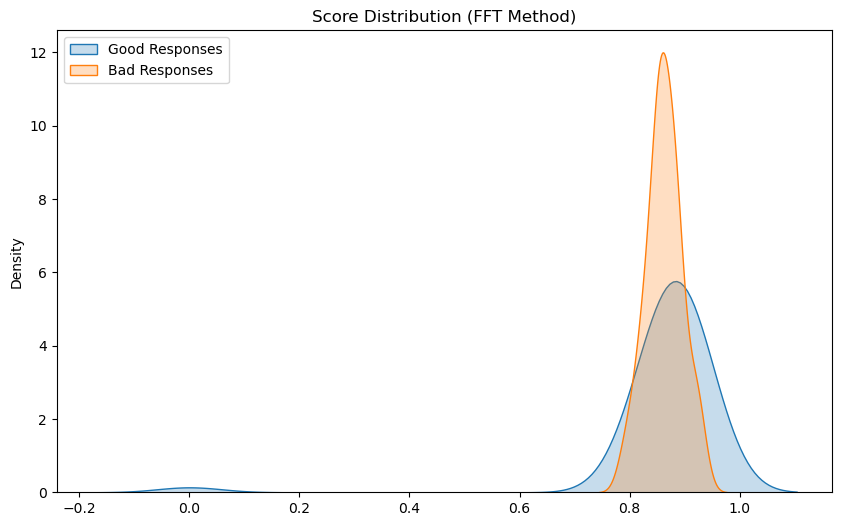

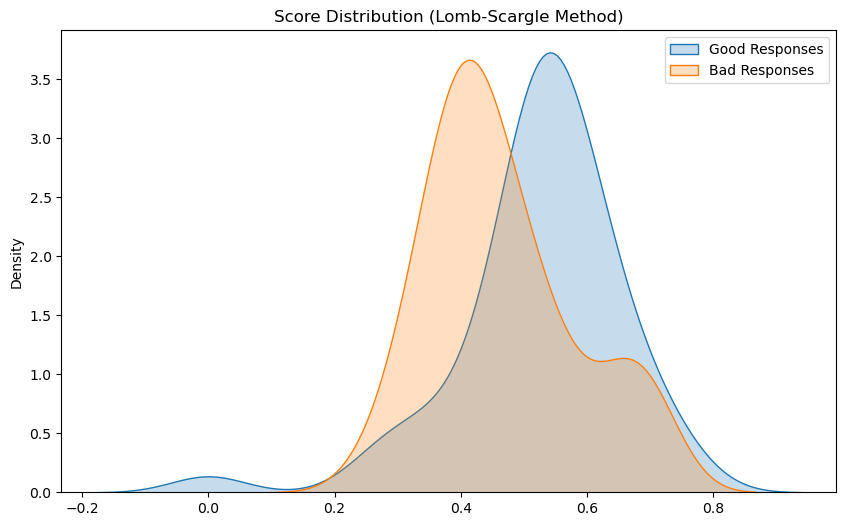

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


# --- Plot for the FFT Method ---
plt.figure(figsize=(10, 6))
sns.kdeplot(good_fft_scores, label='Good Responses', fill=True)
sns.kdeplot(bad_fft_scores, label='Bad Responses', fill=True)
plt.title('Score Distribution (FFT Method)')
plt.legend()
plt.show()

# --- Plot for the Lomb-Scargle Method ---
plt.figure(figsize=(10, 6))
sns.kdeplot(good_lombscargle_scores, label='Good Responses', fill=True)
sns.kdeplot(bad_lombscargle_scores, label='Bad Responses', fill=True)
plt.title('Score Distribution (Lomb-Scargle Method)')
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

fft_auc = roc_auc_score(labels, fft_all_scores)
lombscargle_auc = roc_auc_score(labels, lombscargle_all_scores)

print(f"\nFFT Method AUC: {fft_auc:.4f}")
print(f"Lomb-Scargle Method AUC: {lombscargle_auc:.4f}")

if lombscargle_auc > fft_auc:
    print("Conclusion: Lomb-Scargle is the better method.")
else:
    print("Conclusion: FFT is the better method.")


FFT Method AUC: 0.6460
Lomb-Scargle Method AUC: 0.6872
Conclusion: Lomb-Scargle is the better method.
